# HOMEWORK 1

## DATABASE CREATION

In [1]:
pip install pandas

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install openpyxl

In [40]:
pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install numpy 

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

In [6]:
#Monthly_reurn include 278 months and 2051 firms (rows)
monthly_return_index_path = '/Users/camillevermenouze/Documents/SMTS2/SEF/ESG_Scores/DS_RI_T_USD_M.xlsx'  # Replace with your Excel file name
df_monthly_ri = pd.read_excel(monthly_return_index_path)



#Monthly_capitalization include 278 months and 2051 firms 
monthly_capitalization_path = '/Users/camillevermenouze/Documents/SMTS2/SEF/ESG_Scores/DS_MV_USD_M.xlsx'  # Replace with your Excel file name
df_monthly_capitalization = pd.read_excel(monthly_capitalization_path)



#M ountry to region data
region_path = '/Users/camillevermenouze/Documents/SMTS2/SEF/CountriesToRegions.xlsx'  # Replace with your Excel file name
df_region = pd.read_excel(region_path)

In [7]:
df_region

,% AMER: Cnada + USA,Unnamed: 1,Unnamed: 2
0,% FRON: Frontier countries,NaN,NaN
1,% SA: Standalone countries,NaN,NaN
2,% EM: Emerging markets,NaN,NaN
3,NaN,NaN,NaN
4,Code,Name,Region
...,...,...,...
97,US,UNITED STATES,AMER
98,VI,"VIRGIN ISLANDS, BRITISH",Other
99,VN,VIET NAM,FRON
100,ZA,SOUTH AFRICA,EM


In [8]:
#let's  keep only the EUR contries

df_region.drop(index=[0,1,2,3], inplace= True )

df_EUR = df_region[df_region['Unnamed: 2'] == 'EUR']

#Rename the column so we can merge later
df_EUR = df_EUR.rename(columns={'% AMER: Cnada + USA' : 'ISIN_First2'})

print(df_EUR)

   ISIN_First2       Unnamed: 1 Unnamed: 2
7           AT          AUSTRIA        EUR
11          BE          BELGIUM        EUR
19          CH      SWITZERLAND        EUR
26          DE          GERMANY        EUR
27          DK          DENMARK        EUR
30          ES            SPAIN        EUR
31          FI          FINLAND        EUR
32          FR          FRANCE         EUR
33          GB  UNITED KINGDOM         EUR
43          IE          IRELAND        EUR
44          IL          ISRAEL         EUR
48          IT            ITALY        EUR
71          NL      NETHERLANDS        EUR
72          NO          NORWAY         EUR
80          PT        PORTUGAL         EUR
87          SE          SWEDEN         EUR


In [9]:
#Now merged with the two dataset 
#First step we need to create a new columns with only the 2 first characters of the columns ISIN

#First with the return data 

df_monthly_ri['ISIN_First2'] = df_monthly_ri ['ISIN'].str[:2]
df_monthly_ri.head()

,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,...,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,ISIN_First2
0,AN8068571086,SCHLUMBERGER,1858.26,2254.15,2334.75,2336.65,2245.09,2283.70,2262.67,2610.77,...,3603.19,4261.29,3315.58,3433.33,3537.17,3344.15,4846.68,4801.97,4997.02,AN
1,ARALUA010258,ALUAR,1820.11,1911.12,1866.11,1835.93,1805.22,1657.42,1911.95,1982.99,...,4024.78,3845.16,3472.87,5651.92,5459.78,4847.48,4827.59,5377.66,5524.11,AR
2,ARP125991090,BBVA BANCO FRANCES,396.54,467.49,418.37,350.66,352.52,401.75,404.48,398.47,...,185.10,185.83,170.00,224.44,242.69,242.21,225.97,240.64,299.57,AR
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,177.53,184.55,184.16,171.05,112.65,120.55,124.93,137.21,...,1141.96,1055.43,1025.82,1373.67,1428.06,1263.78,1286.25,1257.52,1463.58,AR
4,AT00000VIE62,FLUGHAFEN WIEN,156.25,153.83,158.62,137.27,148.95,159.68,151.08,153.35,...,1044.97,1035.49,1258.39,1229.26,1215.93,1190.06,1198.76,1248.90,1269.03,AT


In [10]:
#With the capitalization now
df_monthly_capitalization['ISIN_First2'] = df_monthly_capitalization ['ISIN'].str[:2]
df_monthly_capitalization.head()

,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,...,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,ISIN_First2
0,AN8068571086,SCHLUMBERGER,33574.85,40611.13,43352.43,43387.86,41861.39,42466.02,42074.79,48547.80,...,55139.08,64962.64,50578.51,52374.81,53958.90,50906.19,73778.56,73097.94,75806.25,AN
1,ARALUA010258,ALUAR,1328.64,1395.07,1362.23,1340.19,1317.78,1209.89,1395.69,1447.55,...,2195.00,2097.04,1894.01,3013.90,2911.44,2584.93,2574.33,2778.90,2853.52,AR
2,ARP125991090,BBVA BANCO FRANCES,1570.39,1851.34,1656.82,1388.70,1352.22,1541.05,1551.54,1528.48,...,1081.26,1085.52,993.08,1227.99,1318.36,1308.06,1206.71,1285.05,1591.32,AR
3,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,1407.47,1463.08,1460.01,1356.04,893.05,955.70,990.45,1087.76,...,4778.90,4416.77,4292.86,5748.56,5673.71,5021.04,5110.32,4996.17,5814.86,AR
4,AT00000VIE62,FLUGHAFEN WIEN,567.85,559.05,576.48,498.86,517.64,554.94,525.07,532.96,...,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21,AT


In [11]:
#Second step we merge the data set with the region, keeping only the one matching the EUR countries
df_EUR_monthly_capitalization = pd.merge(df_EUR,  df_monthly_capitalization, on='ISIN_First2', how='inner')
df_EUR_monthly_ri = pd.merge(df_EUR,  df_monthly_ri, on='ISIN_First2', how='inner')

In [12]:
df_EUR_monthly_capitalization.head()

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,567.85,559.05,576.48,498.86,517.64,...,2453.36,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,1803.98,1857.91,1910.40,1827.24,1810.26,...,15823.98,13448.16,13356.15,10873.35,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54
2,AT,AUSTRIA,EUR,AT0000743059,OMV,2583.84,2113.74,2065.10,2223.10,2305.32,...,15799.81,16951.82,19071.10,15313.75,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,1655.07,1781.21,1618.73,1446.45,1554.72,...,18088.45,18353.60,16894.99,16612.75,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,1386.43,1283.95,1428.44,1487.43,1567.26,...,3511.64,3280.93,3173.55,2466.15,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25


In [13]:
df_EUR_monthly_ri.head()

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,156.25,153.83,158.62,137.27,148.95,...,1073.50,1044.97,1035.49,1258.39,1229.26,1215.93,1190.06,1198.76,1248.90,1269.03
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,94.91,97.74,100.50,96.13,97.86,...,567.30,482.13,504.75,410.92,409.07,367.15,360.26,400.68,495.04,518.33
2,AT,AUSTRIA,EUR,AT0000743059,OMV,389.64,318.75,311.41,335.24,356.91,...,4277.87,4589.77,5163.58,4341.76,3918.78,3758.17,3396.99,4277.10,4792.28,4763.37
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,524.60,564.59,518.56,463.37,498.05,...,8285.25,8406.71,7820.72,7690.07,8637.53,7555.23,6751.05,6172.06,6981.93,6614.67
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,2379.46,2203.58,2451.55,2552.81,2746.80,...,6331.35,5915.37,5895.80,4581.59,4896.37,5022.24,4318.66,4894.01,5548.18,5152.51


In [14]:
df_EUR_monthly_capitalization.to_csv('/Users/camillevermenouze/Documents/SMTS2/SEF/df_EUR_monthly_capitalization.csv', index=False)
df_EUR_monthly_ri.to_csv('/Users/camillevermenouze/Documents/SMTS2/SEF/df_EUR_monthly_return.csv', index=False)
#We have now 508 firms with the data for 281 months

## IMPORT MONTHLY DATASET

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
urlmri = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_return.csv"
dfmri = pd.read_csv(urlmri)

urlmcapitalization = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_capitalization.csv"
dfmcapitalization = pd.read_csv(urlmcapitalization)

In [5]:
dfmri.head()

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,156.25,153.83,158.62,137.27,148.95,...,1073.50,1044.97,1035.49,1258.39,1229.26,1215.93,1190.06,1198.76,1248.90,1269.03
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,94.91,97.74,100.50,96.13,97.86,...,567.30,482.13,504.75,410.92,409.07,367.15,360.26,400.68,495.04,518.33
2,AT,AUSTRIA,EUR,AT0000743059,OMV,389.64,318.75,311.41,335.24,356.91,...,4277.87,4589.77,5163.58,4341.76,3918.78,3758.17,3396.99,4277.10,4792.28,4763.37
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,524.60,564.59,518.56,463.37,498.05,...,8285.25,8406.71,7820.72,7690.07,8637.53,7555.23,6751.05,6172.06,6981.93,6614.67
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,2379.46,2203.58,2451.55,2552.81,2746.80,...,6331.35,5915.37,5895.80,4581.59,4896.37,5022.24,4318.66,4894.01,5548.18,5152.51


In [6]:
dfmcapitalization.head()

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,567.85,559.05,576.48,498.86,517.64,...,2453.36,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,1803.98,1857.91,1910.40,1827.24,1810.26,...,15823.98,13448.16,13356.15,10873.35,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54
2,AT,AUSTRIA,EUR,AT0000743059,OMV,2583.84,2113.74,2065.10,2223.10,2305.32,...,15799.81,16951.82,19071.10,15313.75,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,1655.07,1781.21,1618.73,1446.45,1554.72,...,18088.45,18353.60,16894.99,16612.75,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,1386.43,1283.95,1428.44,1487.43,1567.26,...,3511.64,3280.93,3173.55,2466.15,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25


## IMPORT YEARLY DATASET

In [7]:
urlyri = 'https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_return.csv'
dfyri = pd.read_csv(urlyri)

urlycapitalization = 'https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_capitalization.csv'
dfycapitalization = pd.read_csv(urlycapitalization)

In [8]:
dfyri.head()

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,...,x2013,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,147.79,169.02,126.01,166.81,248.09,...,684.58,771.62,806.23,853.19,1422.45,1416.63,1557.53,1369.41,1111.83,1269.03
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,102.94,108.87,131.07,169.47,316.50,...,451.57,303.59,409.64,391.16,594.97,471.37,557.68,451.74,724.56,518.33
2,AT,AUSTRIA,EUR,AT0000743059,OMV,393.88,323.77,363.83,444.88,698.11,...,3044.74,1763.66,1970.76,2554.70,4696.74,3335.71,4458.82,3450.98,5033.33,4763.37
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,669.42,490.55,365.21,421.52,588.39,...,1382.09,1279.70,907.90,1161.74,1787.80,3197.60,3808.49,6593.93,8769.64,6614.67
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,2579.95,2186.26,1776.97,2322.13,3626.22,...,2882.81,2537.95,3437.56,3262.29,4602.01,3984.99,5887.01,6511.05,7637.80,5152.51


In [9]:
dfycapitalization.head()

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,x1999,x2000,x2001,x2002,x2003,...,x2013,x2014,x2015,x2016,x2017,x2018,x2019,x2020,x2021,x2022
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,537.09,794.55,560.96,705.15,985.36,...,1765.22,1952.09,1998.43,2073.22,3394.09,3312.76,3559.53,3129.62,2540.95,2900.21
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,1956.67,2269.47,2677.13,4006.48,7354.92,...,15002.04,10003.77,13498.31,12613.95,18633.43,14272.63,16191.42,13115.57,20210.51,13715.54
2,AT,AUSTRIA,EUR,AT0000743059,OMV,2611.95,2091.29,2262.75,2651.31,4021.35,...,15689.64,8716.35,9289.96,11584.60,20761.05,14309.77,18398.00,13214.41,18590.05,16800.81
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,2111.95,1531.28,1129.55,1285.83,1763.91,...,3639.54,3150.65,2193.28,2724.73,4117.86,7246.80,8549.44,14549.09,19145.95,14289.58
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,1503.25,1247.43,974.04,1161.06,1743.94,...,1866.50,1627.64,2198.92,2044.74,2846.44,2418.25,3450.66,3675.69,4236.26,2690.25


## TASK 1

Compute the annualized average RI and annualized volatility for all individual assets over the period 2008–2022. Plot and comment the histogram of these distributions. 

In [10]:
import seaborn as sns

In [11]:
import numpy as np

### Annualized average RI

In [12]:
dfmcapitalization.drop(dfmcapitalization.columns[:4], axis=1, inplace=True)

In [21]:
dfmcapitalization.set_index('NAME', inplace = True)
dfmcapitalizationpost = dfmcapitalization.loc[:, (dfmcapitalization.columns >= '2008-01-01')]
dfmcapitalizationpost

,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,2008-10-31 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
NAME,,,,,,,,,,,,,,,,,,,,,
FLUGHAFEN WIEN,2329.71,2405.60,2539.90,2654.84,2412.28,2004.98,1788.33,1712.25,1311.39,851.86,...,2453.36,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21
ERSTE GROUP BANK,16951.92,18485.57,20573.03,23489.06,24118.28,19703.31,20356.52,19083.13,15304.40,8318.12,...,15823.98,13448.16,13356.15,10873.35,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54
OMV,21320.11,21814.48,19898.56,22629.68,24671.05,23566.34,20782.60,19328.25,12358.80,9506.49,...,15799.81,16951.82,19071.10,15313.75,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81
VERBUND,9860.39,11244.90,10789.72,11694.93,12743.09,13542.92,12045.23,11463.98,9152.77,7085.38,...,18088.45,18353.60,16894.99,16612.75,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58
WIENERBERGER,3809.48,4090.74,4481.37,4838.47,4447.15,3527.37,2265.95,2224.72,2237.94,1373.19,...,3511.64,3280.93,3173.55,2466.15,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIBE INDUSTRIER,798.22,782.09,752.45,671.00,646.89,590.73,603.19,555.81,553.63,431.02,...,20097.57,17739.52,15508.29,13362.37,17802.84,16809.54,16082.16,14214.49,16381.75,16615.26
ELECTROLUX B,4632.15,4852.91,4923.03,4595.81,4313.06,3832.72,3636.54,3869.59,3424.56,2679.39,...,4617.69,4245.08,4258.84,3692.71,3933.26,3496.16,2878.77,3389.53,3828.45,3714.02
ATLAS COPCO A,11805.31,13196.58,14367.51,13514.18,14852.04,12384.34,13107.51,11828.33,9329.62,6838.38,...,44287.14,38732.62,37523.50,31313.66,38867.54,34336.09,31707.46,35865.30,40666.87,39667.59


In [22]:
dfmcapitalizationT = dfmcapitalizationpost.T
dfmcapitalizationT

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2008-01-31 00:00:00,2329.71,16951.92,21320.11,9860.39,3809.48,8006.14,9977.08,2149.78,4301.74,10532.79,...,1687.13,4192.67,5978.81,5820.43,4397.79,798.22,4632.15,11805.31,3089.90,2589.58
2008-02-29 00:00:00,2405.60,18485.57,21814.48,11244.90,4090.74,8828.94,10434.43,2253.98,5002.95,10704.38,...,1974.02,4140.66,6478.96,6274.85,5249.61,782.09,4852.91,13196.58,3406.39,3330.94
2008-03-31 00:00:00,2539.90,20573.03,19898.56,10789.72,4481.37,8074.23,11464.60,2228.23,4989.29,10846.99,...,1910.95,4064.84,6833.09,5830.83,5173.41,752.45,4923.03,14367.51,3621.19,3087.41
2008-04-30 00:00:00,2654.84,23489.06,22629.68,11694.93,4838.47,9581.59,12608.82,2301.74,5066.68,12451.35,...,1674.73,4583.28,7189.28,5857.79,4610.68,671.00,4595.81,13514.18,3807.59,3151.09
2008-05-31 00:00:00,2412.28,24118.28,24671.05,12743.09,4447.15,9722.71,13689.03,2287.15,5399.53,12129.17,...,1560.18,4654.90,7526.33,5424.91,5256.57,646.89,4313.06,14852.04,3614.83,3085.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00,2778.87,9715.28,13255.37,16321.45,2703.34,3043.93,3612.25,2996.46,2063.65,8585.01,...,2940.99,3479.40,20847.37,15360.14,26713.27,16809.54,3496.16,34336.09,1119.39,8836.91
2022-09-30 00:00:00,2719.75,9532.79,11981.47,14584.20,2324.62,2620.80,3062.82,2586.32,1695.41,8260.50,...,2262.35,3227.76,19272.98,15116.01,24484.81,16082.16,2878.77,31707.46,846.93,8541.12
2022-10-31 00:00:00,2739.62,10602.50,15085.69,13333.42,2634.32,2865.33,3878.67,2846.36,1636.38,9547.28,...,2400.10,2997.73,21199.72,15677.18,25645.89,14214.49,3389.53,35865.30,951.81,7959.95
2022-11-30 00:00:00,2854.20,13099.32,16902.76,15082.96,2896.84,2939.04,4772.57,3336.07,1753.36,10234.37,...,2699.29,3626.43,23377.18,16445.79,28753.87,16381.75,3828.45,40666.87,978.44,9949.04


In [19]:
print(dfmcapitalizationT.dtypes)

0      object
1      object
2      object
3      object
4      object
        ...  
503    object
504    object
505    object
506    object
507    object
Length: 508, dtype: object


In [23]:
dfmreturns = dfmcapitalizationT.pct_change()

In [24]:
dfmreturns

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2008-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-29 00:00:00,0.032575,0.090471,0.023188,0.140411,0.073832,0.102771,0.045840,0.048470,0.163006,0.016291,...,0.170046,-0.012405,0.083654,0.078073,0.193693,-0.020207,0.047658,0.117851,0.102427,0.286286
2008-03-31 00:00:00,0.055828,0.112924,-0.087828,-0.040479,0.095491,-0.085481,0.098728,-0.011424,-0.002730,0.013323,...,-0.031950,-0.018311,0.054658,-0.070762,-0.014515,-0.037898,0.014449,0.088730,0.063058,-0.073111
2008-04-30 00:00:00,0.045254,0.141740,0.137252,0.083896,0.079685,0.186688,0.099805,0.032990,0.015511,0.147908,...,-0.123614,0.127543,0.052127,0.004624,-0.108774,-0.108246,-0.066467,-0.059393,0.051475,0.020626
2008-05-31 00:00:00,-0.091365,0.026788,0.090208,0.089625,-0.080877,0.014728,0.085671,-0.006339,0.065694,-0.025875,...,-0.068399,0.015626,0.046882,-0.073898,0.140086,-0.035931,-0.061523,0.098997,-0.050625,-0.020701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00,-0.010835,-0.102478,-0.040986,-0.125302,0.025706,0.041190,-0.093998,-0.056887,-0.023739,-0.069899,...,-0.127152,-0.196648,-0.180800,-0.033070,-0.117771,-0.055794,-0.111129,-0.116587,-0.143667,-0.022415
2022-09-30 00:00:00,-0.021275,-0.018784,-0.096104,-0.106440,-0.140093,-0.139008,-0.152102,-0.136875,-0.178441,-0.037800,...,-0.230752,-0.072323,-0.075520,-0.015894,-0.083421,-0.043272,-0.176591,-0.076556,-0.243400,-0.033472
2022-10-31 00:00:00,0.007306,0.112214,0.259085,-0.085763,0.133226,0.093304,0.266372,0.100544,-0.034818,0.155775,...,0.060888,-0.071266,0.099971,0.037124,0.047420,-0.116133,0.177423,0.131131,0.123835,-0.068044
2022-11-30 00:00:00,0.041823,0.235494,0.120450,0.131215,0.099654,0.025725,0.230466,0.172048,0.071487,0.071967,...,0.124657,0.209725,0.102712,0.049027,0.121188,0.152468,0.129493,0.133878,0.027978,0.249887


In [26]:
dfannualizedreturns = dfmreturns.mean() * 12

In [89]:
dfannualizedreturns

NAME
FLUGHAFEN WIEN              0.115048
ERSTE GROUP BANK            0.178020
OMV                         0.145874
VERBUND                     0.144949
WIENERBERGER                0.105628
                              ...   
NIBE INDUSTRIER             0.304830
ELECTROLUX B                0.039094
ATLAS COPCO A               0.158279
MODERN TIMES GROUP MTG B    0.096511
BOLIDEN ORD SHS             0.353588
Length: 508, dtype: float64

<Axes: xlabel='NAME'>

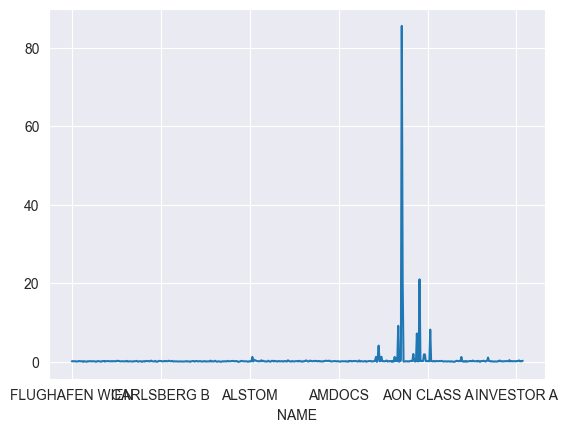

In [27]:
dfannualizedreturns.plot()

<Axes: ylabel='Count'>

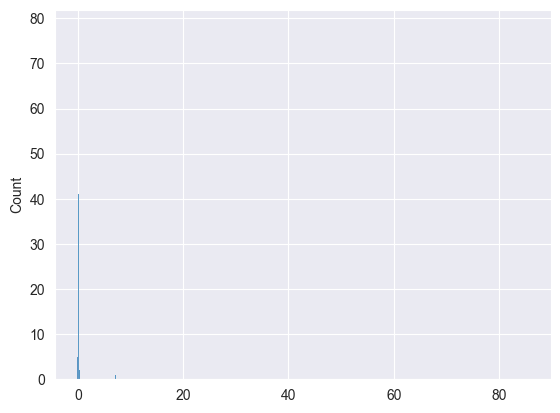

In [28]:
sns.histplot(dfannualizedreturns)

### Annualized volatility

In [29]:
deviations = dfmreturns - dfmreturns.mean()
squared_deviations = deviations**2
mean_squared_deviations = squared_deviations.mean()

dfmvolatility = np.sqrt(mean_squared_deviations)
dfmvolatility

NAME
FLUGHAFEN WIEN              0.091528
ERSTE GROUP BANK            0.138056
OMV                         0.108334
VERBUND                     0.097245
WIENERBERGER                0.126344
                              ...   
NIBE INDUSTRIER             0.099388
ELECTROLUX B                0.106980
ATLAS COPCO A               0.090878
MODERN TIMES GROUP MTG B    0.142225
BOLIDEN ORD SHS             0.138877
Length: 508, dtype: float64

In [30]:
dfannualizedvolatility = dfmvolatility*(12**0.5)
dfannualizedvolatility

NAME
FLUGHAFEN WIEN              0.317062
ERSTE GROUP BANK            0.478240
OMV                         0.375280
VERBUND                     0.336867
WIENERBERGER                0.437669
                              ...   
NIBE INDUSTRIER             0.344290
ELECTROLUX B                0.370590
ATLAS COPCO A               0.314810
MODERN TIMES GROUP MTG B    0.492681
BOLIDEN ORD SHS             0.481085
Length: 508, dtype: float64

<Axes: xlabel='NAME'>

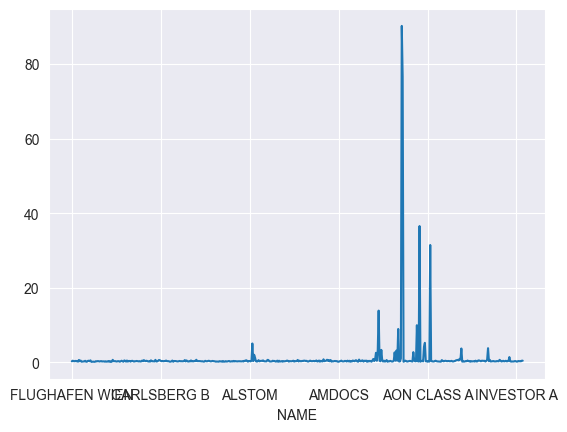

In [31]:
dfannualizedvolatility.plot()

Compute and comment on the correlation between individual average RIs and volatilities in the cross section.

### Correlation

In [32]:
df = pd.DataFrame()
df["returns"]=dfannualizedreturns

In [33]:
df["volatility"]=dfannualizedvolatility

In [34]:
df.corr

<bound method DataFrame.corr of                            returns  volatility
NAME                                          
FLUGHAFEN WIEN            0.065887    0.317062
ERSTE GROUP BANK          0.103001    0.478240
OMV                       0.055039    0.375280
VERBUND                   0.081249    0.336867
WIENERBERGER              0.075192    0.437669
...                            ...         ...
NIBE INDUSTRIER           0.263831    0.344290
ELECTROLUX B              0.052809    0.370590
ATLAS COPCO A             0.131840    0.314810
MODERN TIMES GROUP MTG B  0.060201    0.492681
BOLIDEN ORD SHS           0.201660    0.481085

[508 rows x 2 columns]>

In [35]:
df["corr"] = 0
for i in df.index:
    df.loc[i, "corr"] = df.loc[i, "returns"].corr(df.loc[i, "volatility"], method="pearson")

AttributeError: 'numpy.float64' object has no attribute 'corr'

In [109]:
df.loc[i]["corr"]


0.0

## TASK 2

Report the following statistics for both portfolios (equally-weighted portfolio & the market-cap weighted portfolio with monthly rebalancing over the period 2008–2022): annualized average return, annualized volatility, Sharpe ratio, minimum return, and maximum return. Plot the time series of cumulated returns for both portfolios. (15 points)

### Equally-weighted portfolio

In [36]:
#Creating a vector with equal weights for the 508 firms
n_columns = 508

#df_weight = pd.DataFrame([1/n_columns] * n_columns).T
weight = 1/508
weight

0.001968503937007874

In [37]:
#Equally weighted portfolio (average returns of all firms per each month)
mreturnsEW = (dfmreturns * weight).sum(axis=1)
mreturnsEW

2008-01-31 00:00:00    0.000000
2008-02-29 00:00:00    0.035499
2008-03-31 00:00:00    0.013891
2008-04-30 00:00:00    0.017129
2008-05-31 00:00:00    0.001064
                         ...   
2022-08-31 00:00:00   -0.068045
2022-09-30 00:00:00   -0.119233
2022-10-31 00:00:00    0.099507
2022-11-30 00:00:00    0.107013
2022-12-31 00:00:00    0.011110
Length: 180, dtype: float64

In [38]:
annualizedmreturnsEW = ((1+ mreturnsEW.mean())*12)-1
annualizedmreturnsEW

11.406284087785595

### Market-cap portfolio

In [39]:
# Calculate weights for each month based on previous month's capitalization
totalcapprevious = dfmcapitalizationT.shift(0).sum(axis=1)
weights = dfmcapitalizationT.shift(0).div(totalcapprevious, axis=0)

# Calculate the value-weighted portfolio returns
portfolioreturnsVW = (dfmreturns.shift(1) * weights).sum(axis=1)
portfolioreturnsVW


2008-01-31 00:00:00    0.000000
2008-02-29 00:00:00    0.000000
2008-03-31 00:00:00    0.021868
2008-04-30 00:00:00    0.008346
2008-05-31 00:00:00    0.041265
                         ...   
2022-08-31 00:00:00    0.049530
2022-09-30 00:00:00   -0.057216
2022-10-31 00:00:00   -0.083940
2022-11-30 00:00:00    0.079450
2022-12-31 00:00:00    0.115599
Length: 180, dtype: float64

In [40]:
dfmreturns = dfmcapitalizationT.pct_change()